## Import libraries

In [11]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import nltk
import numpy as np
import re
import string
from nltk.corpus import stopwords

## Analyse and preprocess the dataset

In [12]:
data = pd.read_csv('Data/tweets/tweets.csv', encoding='latin', names=['polarity','id','date','query','user','text'])

In [13]:
data.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
print("Dataset shape:", data.shape)

Dataset shape: (1600000, 6)


In [15]:
data = data.sample(frac=1)
data = data[:200000]

In [16]:
#Unique output values
data['polarity'].unique()

array([0, 4])

In [17]:
#4 denotes positive. We'll replace 4 with 1 for easy understanding

data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
255803,0,1984576145,Sun May 31 15:22:48 PDT 2009,NO_QUERY,trwhite88,@TheNickAdams Chin-up!
1069559,1,1965949842,Fri May 29 16:50:37 PDT 2009,NO_QUERY,SoleneD,@TweetFakes Okay thx ) . When are u born ? (r...
782800,0,2323752411,Thu Jun 25 01:23:55 PDT 2009,NO_QUERY,ElliotTucker,"Google blocked in China, can't use Gmail, Goog..."
1032075,1,1933149927,Tue May 26 23:07:34 PDT 2009,NO_QUERY,cynabun87,loved SD but hating the recovery !
101105,0,1794264746,Thu May 14 05:23:40 PDT 2009,NO_QUERY,rahyu,"WHATEVER YOU LIKE, sayonara"


In [18]:
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.500655,1.999031e+09
std,0.500001,1.937347e+08
min,0.000000,1.467810e+09
25%,0.000000,1.956926e+09
50%,1.000000,2.002163e+09
75%,1.000000,2.177229e+09
max,1.000000,2.329205e+09


Total sentences:  200000
Negative sentences:  100131
Positive sentences:  99869


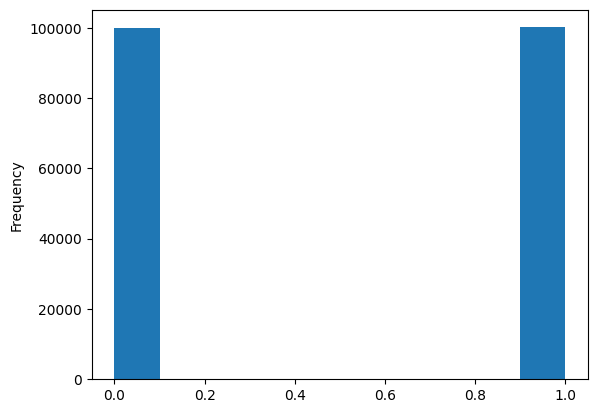

In [19]:
#Count of posive and negative sentences
data['polarity'].plot(kind='hist')
print('Total sentences: ',data.shape[0])
print('Negative sentences: ',len(data[data['polarity'] == 1]))
print('Positive sentences: ',len(data[data['polarity'] == 0]))

In [20]:
#Get word count for a given text
def word_count(words):
    return len(words.split())

**Word count of positive and negative tweets**

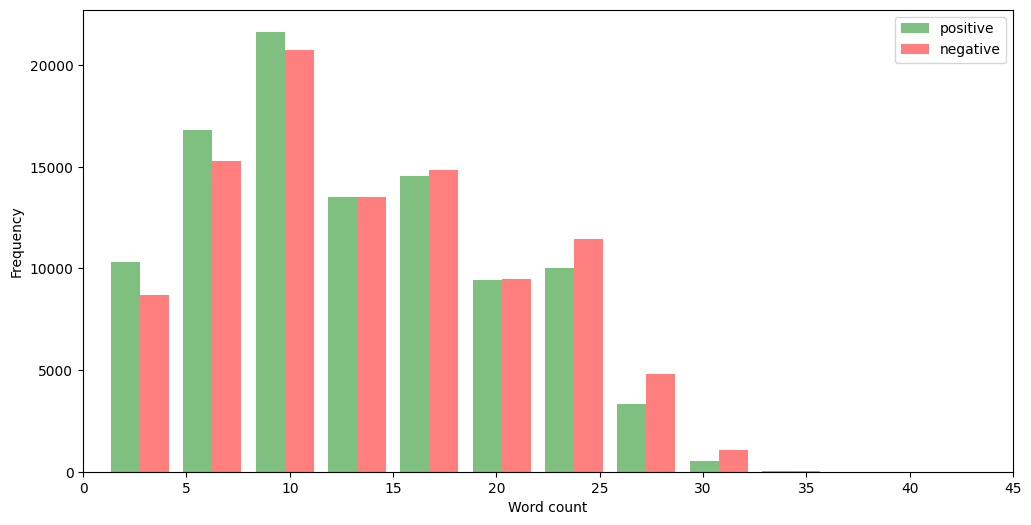

In [21]:
#Word distribution for positive and negative words

data['word count'] = data['text'].apply(word_count)
wc_pos = data[data['polarity'] == 1]['word count']
wc_neg = data[data['polarity'] == 0]['word count']

plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')

g = plt.hist([wc_pos, wc_neg], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

**Common words**

In [22]:
#Get common words and displaying the 20 most common ones
from collections import Counter
all_words = []

for line in list(data['text']):
    words = line.split()
    for word in words:
        if(len(word) > 2):
            all_words.append(word.lower())

Counter(all_words).most_common(20)

[('the', 64779),
 ('and', 36597),
 ('you', 29833),
 ('for', 26579),
 ('have', 17867),
 ('that', 16052),
 ("i'm", 15997),
 ('but', 15487),
 ('just', 15311),
 ('with', 14092),
 ('was', 12845),
 ('not', 12697),
 ('this', 11014),
 ('get', 9995),
 ('good', 9625),
 ('are', 9558),
 ('like', 9500),
 ('all', 9261),
 ('out', 8633),
 ('your', 8160)]

In [23]:
#Removing the columns which are not necessary
data.drop(['id','date', 'query', 'user','word count'], axis=1, inplace=True)

In [24]:
data

,polarity,text
255803,0,@TheNickAdams Chin-up!
1069559,1,@TweetFakes Okay thx ) . When are u born ? (r...
782800,0,"Google blocked in China, can't use Gmail, Goog..."
1032075,1,loved SD but hating the recovery !
101105,0,"WHATEVER YOU LIKE, sayonara"
...,...,...
41617,0,Tuesday and I are going to watch scary movies....
474292,0,waking up to realize last night wasnt a dream
458164,0,had an awesome weekend...hello monday morning
420918,0,@RubeZzz I feel sorry for myself haha nah jk...


In [25]:
#Checking for null values
print(data.isnull().sum())

polarity    0
text        0
dtype: int64


In [26]:
data.dtypes

polarity     int64
text        object
dtype: object

In [27]:
#Converting text from object type to str
data['text'] = data['text'].astype('str')

**Download stopwords**

In [28]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/surbhit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/surbhit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/surbhit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
#nltk.download('stopwords')
stopwords_english = set(stopwords.words('english'))
print('Total english stopwords: ', len(stopwords_english))
print(stopwords_english)

Total english stopwords:  179
{'too', 'their', 'where', 'at', 'below', 'both', "hasn't", 'from', 'i', 'more', 'between', 'has', 'shan', 'she', "weren't", 'herself', 'his', 'ours', "wasn't", 'for', 'should', 'had', 'own', 'which', 'out', 're', 'some', 'we', 'all', 'to', 'mustn', 'shouldn', 'hers', 'ma', 'or', 'my', 'just', 'so', 'doesn', 'her', 'was', 'yourselves', 'no', 'down', 'they', 'do', 'and', 'not', 'll', 'wouldn', 'are', 'ourselves', 'nor', 'o', 'against', 'them', 'before', 'what', 'with', 'then', 'an', 'there', "wouldn't", "you'd", 'whom', 'each', 'y', 'if', 'it', 'when', 'why', 'hadn', 'does', 'on', "shouldn't", 'can', 'off', "doesn't", "needn't", "won't", "it's", 'didn', 'him', "mustn't", 'during', 'while', 'couldn', 'such', 'only', 'is', 'after', 've', 'the', 'once', 'into', "couldn't", 'haven', "shan't", 'yours', 'd', 't', 'above', 'again', 'isn', 'very', "aren't", "haven't", 's', 'that', 'did', "you've", 'until', 'ain', 'as', 'any', 'these', 'don', 'themselves', 'now', 'm'

Preprocessing steps:
1. Removing urls, username
2. Convert to lower case
3. Remove punctuations
4. Remove stopwords
5. Tokenization and Lemmetization

In [30]:
#Pattern for finding https:// or http:// or www.
urlPattern = r"((https://)[^ ]*|(http://)[^ ]*|(www\.)[^ ]*)"

#Pattern for finding @<>
userPattern = '@[^\s]+'

def process_text(text):
    #Lower case
    text = text.lower()
    #text = text[1:]

    #Removing urls
    text = re.sub(urlPattern,'',text)
    
    #Removing usernames
    text = re.sub(userPattern,'',text)
    
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    
    #Tokenization
    tokens = word_tokenize(text)
    
    #Removing stopwords
    final_token = [tkn for tkn in tokens if tkn not in stopwords_english]

    #Lemmetization
    wordLemm = WordNetLemmatizer()
    final_words = []
    for t in final_token:
        if len(t) > 1:
            word = wordLemm.lemmatize(t)
            final_words.append(word)

    return ' '.join(final_words)

In [31]:
data['processed_tweets'] = data['text'].apply(lambda x:process_text(x))
print('Text preprocessing complete')

Text preprocessing complete


In [32]:
data.head()

,polarity,text,processed_tweets
255803,0,@TheNickAdams Chin-up!,chinup
1069559,1,@TweetFakes Okay thx ) . When are u born ? (r...,okay thx born really anottired subject machine...
782800,0,"Google blocked in China, can't use Gmail, Goog...",google blocked china cant use gmail google app...
1032075,1,loved SD but hating the recovery !,loved sd hating recovery
101105,0,"WHATEVER YOU LIKE, sayonara",whatever like sayonara


In [33]:
def create_word_cloud(feature,polarity_value,max_words=2000, width=1600, height=800):
    plt.figure(figsize=(15,15))
    wc = WordCloud(max_words=max_words, width=width, height=height).generate(" ".join(data[data[feature] == polarity_value].processed_tweets))
    plt.imshow(wc , interpolation = 'bilinear')

**Wordcloud for negative words**

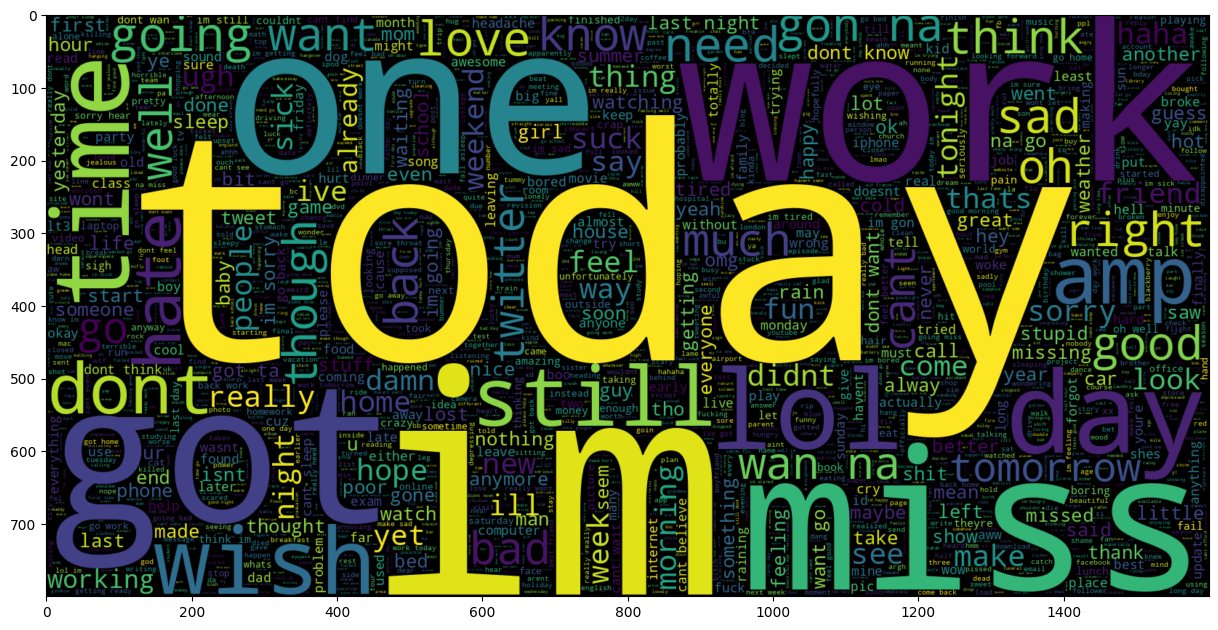

In [34]:
#Wordcloud for negative words
create_word_cloud('polarity',0)

**Wordcloud for positive words**

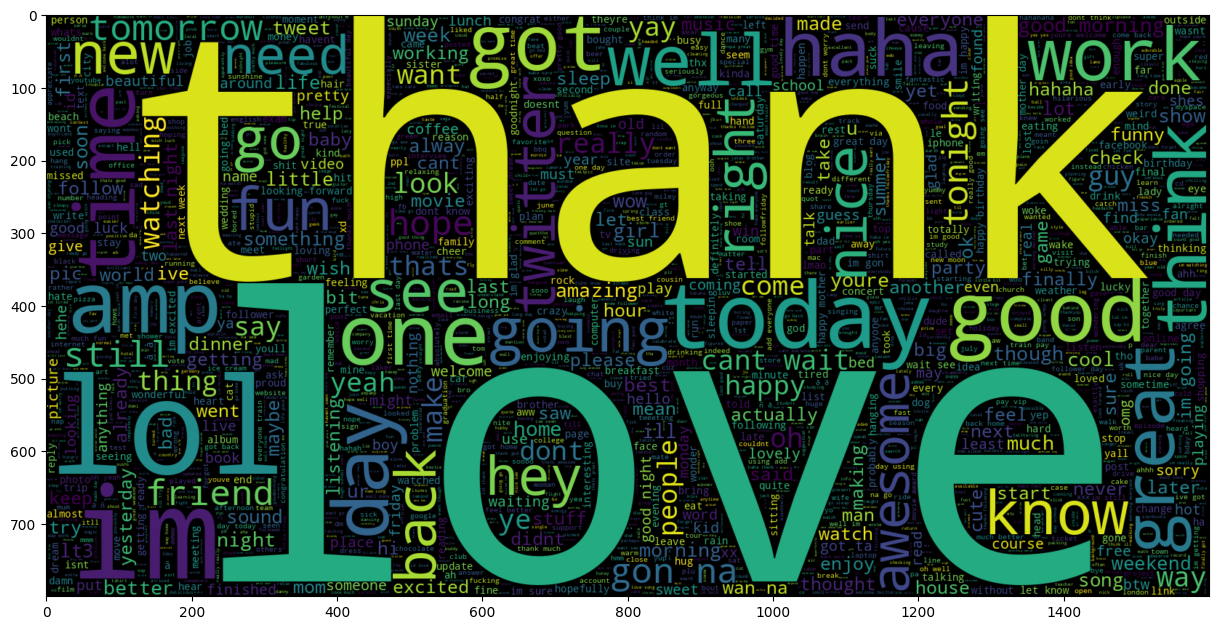

In [35]:
#Wordcloud for positive words
create_word_cloud('polarity',1)

In [36]:
X = data['processed_tweets'].values
y = data['polarity'].values

In [37]:
print('Shape of X: ',X.shape)
print('Shape of y: ',y.shape)

Shape of X:  (200000,)
Shape of y:  (200000,)


## Modelling

**Using TF-IDF**

In [38]:
tfidf = TfidfVectorizer(sublinear_tf=True)
X = tfidf.fit_transform(X)
print('Number of features: ',len(tfidf.get_feature_names_out()))

Number of features:  101350


In [39]:
print(X.shape)
print(y.shape)

(200000, 101350)
(200000,)


**Train(80) and test(20) split**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [41]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 101350)
y_train (160000,)

X_test (40000, 101350)
y_test (40000,)


**This function takes the model as input and does the training and testing. It will also print the confusion matrix and classification report=**

In [42]:
def evaluate_model(model):
    #Training accuracy
    accuracy_train = model.score(X_train, y_train)
    print('Training accuracy: {}'.format(accuracy_train*100))

    #Testing accuracy
    accuracy_test = model.score(X_test, y_test)
    print('Testing accuracy: {}'.format(accuracy_test*100))

    #Prediction on test data
    y_pred = model.predict(X_test)

    #Classification report
    print(classification_report(y_test, y_pred))

    #Confusion matrix
    matrix = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['False', 'True'])
    cm_display.plot()
    plt.show()

**Logistic Regression**

/home/surbhit/anaconda3/envs/TextClassification/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy: 82.058125
Testing accuracy: 76.8825
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     20032
           1       0.76      0.79      0.77     19968

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



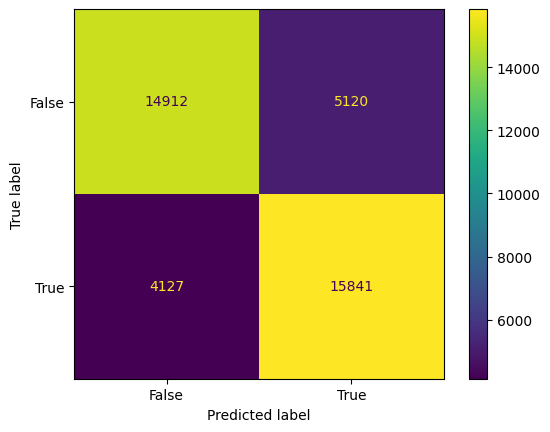

In [43]:
model_log_reg = LogisticRegression()
history_log_reg = model_log_reg.fit(X_train, y_train)
evaluate_model(model_log_reg)

**Linear SVM**

Training accuracy: 88.26
Testing accuracy: 75.4525
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     20032
           1       0.74      0.78      0.76     19968

    accuracy                           0.75     40000
   macro avg       0.76      0.75      0.75     40000
weighted avg       0.76      0.75      0.75     40000



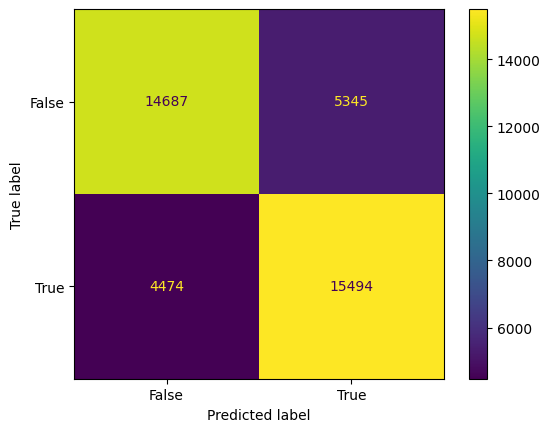

In [44]:
model_svc = LinearSVC()
history_svc = model_svc.fit(X_train, y_train)
evaluate_model(model_svc)

**Random Forest**

Training accuracy: 76.06125
Testing accuracy: 70.94500000000001
              precision    recall  f1-score   support

           0       0.74      0.64      0.69     20032
           1       0.68      0.78      0.73     19968

    accuracy                           0.71     40000
   macro avg       0.71      0.71      0.71     40000
weighted avg       0.71      0.71      0.71     40000



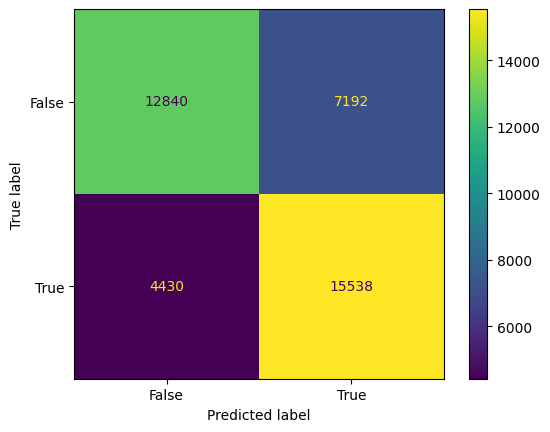

In [45]:
model_rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
history_rf = model_rf.fit(X_train, y_train)
evaluate_model(model_rf)

Training accuracy: 78.805625
Testing accuracy: 73.1625
              precision    recall  f1-score   support

           0       0.76      0.67      0.71     20032
           1       0.71      0.79      0.75     19968

    accuracy                           0.73     40000
   macro avg       0.74      0.73      0.73     40000
weighted avg       0.74      0.73      0.73     40000



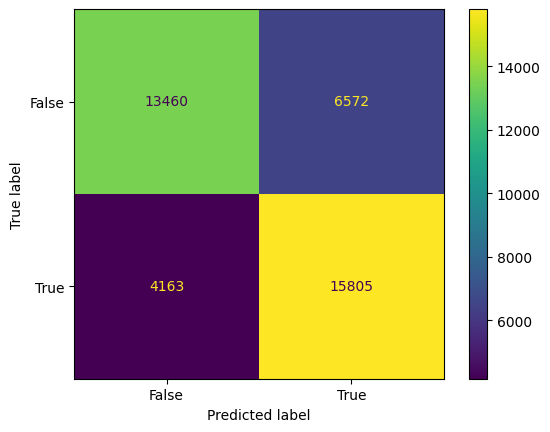

In [46]:
model_rf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth=50)
history_rf = model_rf.fit(X_train, y_train)
evaluate_model(model_rf)

**Naive Bayes**

Training accuracy: 83.41
Testing accuracy: 75.8725
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     20032
           1       0.76      0.76      0.76     19968

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



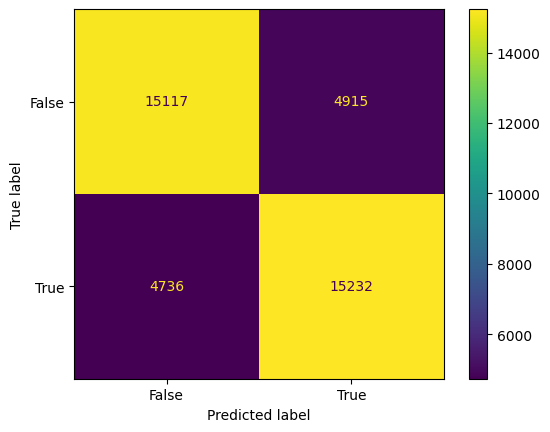

In [47]:
model_nb = BernoulliNB()
history_nb = model_nb.fit(X_train, y_train)
evaluate_model(model_nb)

### Predictions on the models

In [48]:
categories = ["Negative", "Positive"]
def predict(sent,model):
    sent = [sent]
    sentence_test = tfidf.transform(sent)
    pred = model.predict(sentence_test)
    return categories[pred[0]]


In [49]:
#Logistic Regression
p = predict("I enjoy working on this", model_log_reg)
print("I enjoy working on this - ", p)

p = predict("I don't enjoy working on this", model_log_reg)
print("I don't enjoy working on this - ", p)

p = predict("I hate working on this", model_log_reg)
print("I hate working on this - ", p)

I enjoy working on this -  Positive
I don't enjoy working on this -  Positive
I hate working on this -  Negative


In [50]:
#SVC
p = predict('This does not look amazing', model_svc)
print("This does not look amazing - ", p)

p = predict('This looks amazing', model_svc)
print("This looks amazing - ", p)

p = predict('This is horrible', model_svc)
print("This is horrible - ", p)

This does not look amazing -  Positive
This looks amazing -  Positive
This is horrible -  Negative


In [51]:
#Random Forest
p = predict("I enjoy working on this", model_rf)
print("I enjoy working on this - ", p)

p = predict("I don't enjoy working on this", model_rf)
print("I don't enjoy working on this - ", p)

p = predict("I hate working on this", model_rf)
print("I hate working on this - ", p)

I enjoy working on this -  Positive
I don't enjoy working on this -  Positive
I hate working on this -  Negative


In [52]:
#Naive Bayes
p = predict('This does not look amazing', model_nb)
print("This does not look amazing - ", p)

p = predict('This looks amazing', model_nb)
print("This looks amazing - ", p)

p = predict('This is horrible', model_nb)
print("This is horrible - ", p)

This does not look amazing -  Positive
This looks amazing -  Positive
This is horrible -  Negative


**We'll deploy the Naive Bayes model for prediction**

In [53]:
import pickle

In [57]:
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))
pickle.dump(model_nb, open('NaiveBayes.pkl','wb'))

In [66]:
sent = "I hate you"
sent = [sent]
sentence_test = tfidf.transform(sent)
pred = model_nb.predict(sentence_test)

In [67]:
pred

array([0])